# This will be feature selection based on the paper by kniep HC in which they get tid off all those tumors which volume is less than 125 and select the 10 lasrgest metastsis per patient. I am going to go with 15 for now. The rest would be applying the same codes as before. Only the radiomic features of the 3 classes: Melanomma, Lung, Breast (0, 1, 2).

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate, KFold, RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import VotingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_selection import VarianceThreshold
from collections import Counter
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import Pipeline as imbpipeline
from mrmr import mrmr_classif
from scipy import stats
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import f_classif

In [9]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, multi_class='ovr', average=average)

from sklearn.metrics import roc_auc_score

def class_vs_rest_roc_auc_score(y_test, y_pred):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test_bin = lb.transform(y_test)
    y_pred_bin = lb.transform(y_pred)
    roc_auc_scores = {}

    for i, class_label in enumerate(lb.classes_):
        class_indices = lb.transform([class_label])[0]
        rest_indices = ~class_indices
        y_test_class = y_test_bin[:, i]
        y_test_rest = y_test_bin[:, rest_indices]
        y_pred_class = y_pred_bin[:, i]
        y_pred_rest = y_pred_bin[:, rest_indices]
        roc_auc_scores[class_label] = roc_auc_score(y_test_class, y_pred_class, multi_class='ovr', average="macro")

    return roc_auc_scores

def calculate_specificity(cm):
    num_classes = cm.shape[0]
    specificity = {}

    for i in range(num_classes):
        tp = cm[i, i]
        tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
        fp = np.sum(cm[:, i]) - tp
        fn = np.sum(cm[i, :]) - tp

        specificity[i] = 100*(tn / (tn + fp))

    return specificity

def calculate_sensitivity(cm):
    num_classes = cm.shape[0]
    sensitivity = {}

    for i in range(num_classes):
        tp = cm[i, i]
        fn = np.sum(cm[i, :]) - tp

        sensitivity[i] = 100*(tp / (tp + fn))

    return sensitivity


def calculate_precision(cm):
    num_classes = cm.shape[0]
    precision = {}

    for i in range(num_classes):
        tp = cm[i, i]
        fp = np.sum(cm[:, i]) - tp

        precision[i] = 100*(tp / (tp + fp))

    return precision


def calculate_f1_score(cm):
    num_classes = cm.shape[0]
    f1_scores = {}

    for i in range(num_classes):
        tp = cm[i, i]
        fp = np.sum(cm[:, i]) - tp
        fn = np.sum(cm[i, :]) - tp

        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1_scores[i] = 2 * ((precision * recall) / (precision + recall)) * 100

    return f1_scores

def calculate_accuracy(cm):
    num_classes = cm.shape[0]
    accuracy = {}

    for i in range(num_classes):
        tp = cm[i, i]
        fp = np.sum(cm[:, i]) - tp
        fn = np.sum(cm[i, :]) - tp
        tn = np.sum(cm) - tp - fp - fn

        accuracy[i] = 100 * ((tp + tn) / (tp + tn + fp + fn))

    return accuracy

There is an obvious inbalane of the labes wih a great majority coming from the lung. To counter attck this inbalance we eill make use of oversampling and undersapmling techniques that have proven to be useful in literature

## F-CLASSIF

## al my features

In [19]:
df = pd.read_excel('all_patients.xlsx')
#df = df.set_index(['subjid'])
df = df.drop('number_annotations', axis = 1)
df = df[df.shape_VoxelVolume > 125]
df.drop(df[df['labels'] == 3].index, inplace = True) ## dropping label of the call OTHERS
df = df.set_index(['subjid', 'label'])

# we select X and y
X = df.iloc[:, :-4] #leaving the sex and age features out for now
y = df.iloc[:, -1:]
X_age_sex = df.iloc[:, -4:-1]
confidence = 0.95
seed = 0

In [23]:
pipelines = {
    #'rf': imbpipeline([('smoteen', SMOTEENN(random_state=0)),
                       #('clf', RandomForestClassifier(random_state=0, class_weight="balanced"))]),
    'svc': imbpipeline([('smoteen', SMOTEENN(random_state=0)),
                        ('clf', CalibratedClassifierCV(LinearSVC(multi_class='ovr', random_state=0, class_weight="balanced")))])
    }

param_grids = {
    #'rf': {'clf__n_estimators': [100, 250, 1000, 3500]},
    'svc': {'clf__base_estimator__C': [0.1, 1, 10], 'clf__base_estimator__max_iter': [10000, 20000]}
}

cv_outer = RepeatedStratifiedKFold(n_splits=6, n_repeats=6, random_state=seed)

In [24]:
# Store the scores and metrics
scores_svc = {'acc': [], 'SD_acc': [], 'CI_acc': [], 'auc_tot': [], 'SD_auc_tot': [], 'CI_auc_tot': [], 'auc_class': [], 'SD_auc_class': [], 'CI_auc_class': [], 'Sen_mean': [], 'Sen_CI': [], 'Sen_SD': [], 'Spe_mean': [], 'Spe_CI': [], 'Spe_sd': [], 'Pre_mean': [], 'Pre_CI': [], 'Pre_sd': [], 'F1_mean': [], 'F1_CI': [], 'F1_sd': [], 'Accy_mean': [], 'Accy_CI': [], 'Accy_sd': []}
#scores_svc = {'acc': [], 'SD_acc': [], 'CI_acc': [], 'auc_tot': [], 'SD_auc_tot': [], 'CI_auc_tot': [], 'auc_class': [], 'SD_auc_class': [], 'CI_auc_class': [], 'Sen_mean': [], 'Sen_CI':[], 'Sen_SD': [], 'Spe_mean': [], 'Spe_CI': [], 'Spe_sd': []}
best_features_RF = []
num_classes = len(np.unique(y))
sum_confusion_matrix_rf = np.zeros((num_classes, num_classes))
for name, pipeline in pipelines.items():
    # Initialize lists to store scores for each fold
    fold_acc = []
    fold_auc_tot = []
    fold_auc_class = []
    sensi = []
    speci = []
    prec = []
    f1 = []
    accy = []
    features = []
    p_value = []
    feat = []
    value = []
    for train_index, test_index in cv_outer.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        scaler = StandardScaler()
        X_train_normed = scaler.fit_transform(X_train)
        X_test_normed = scaler.transform(X_test)

        X_train_scal = pd.DataFrame(X_train_normed, columns=X_train.columns, index=X_train.index)
        X_test_scal = pd.DataFrame(X_test_normed, columns=X_test.columns, index=X_test.index)

        #select the best 15 features
        additional_columns = ['Age', 'F', 'M']
        X_train_new = X_train_scal.join(X_age_sex[additional_columns])
        X_test_new = X_test_scal.join(X_age_sex[additional_columns])

        cv_inner = RepeatedStratifiedKFold(n_splits=4, n_repeats=4, random_state=seed)
        grid_search = GridSearchCV(pipeline, param_grids[name], cv=cv_inner, scoring='roc_auc_ovr', error_score="raise")
        print(name)
        grid_search.fit(X_train_new, y_train)
        clf = grid_search.best_estimator_
        print(clf)
        clf.fit(X_train_new, y_train)
        y_pred = clf.predict(X_test_new)
        accuracy = accuracy_score(y_test, y_pred)
        num_classes = len(np.unique(y_test))
        cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
        specificity = calculate_specificity(cm)
        sensitivity = calculate_sensitivity(cm)
        precision = calculate_precision(cm)
        F1 = calculate_f1_score(cm)
        Accuracy = calculate_accuracy(cm)
        sum_confusion_matrix_rf += cm
        # Print the results

        accuracy = accuracy_score(y_test, y_pred)
        fold_acc.append(accuracy)

        # Calculate AUC score
        auc_tot = multiclass_roc_auc_score(y_test, y_pred)
        fold_auc_tot.append(auc_tot)

        auc_class = class_vs_rest_roc_auc_score(y_test, y_pred)
        fold_auc_class.append(auc_class)

        speci.append(specificity)
        sensi.append(sensitivity)
        prec.append(precision)
        f1.append(F1)
        accy.append(Accuracy)

        print('Auc Score', multiclass_roc_auc_score(y_test, y_pred))
        print('Auc Score OvR', class_vs_rest_roc_auc_score(y_test, y_pred))

        if name == 'rf':
            params_rf = grid_search.best_estimator_
            feature_importance = clf.named_steps['clf'].feature_importances_

        else:
            continue

    # Calculate average scores across folds
    if name == 'svc':
        print('mamawuevo')
        #acc
        avg_acc = np.mean(fold_acc)
        scores_svc['acc'].append(avg_acc)
        #scores_svc['acc'] = scores_svc['acc'][-1]
        ci = stats.t.interval(confidence, len(fold_acc) - 1, loc=np.mean(fold_acc), scale=stats.sem(fold_acc))
        scores_svc['CI_acc'].append(ci)
        scores_svc['SD_acc'].append(np.std(fold_acc))

        #auc_tot
        avg_auc_tot = np.mean(fold_auc_tot)
        scores_svc['auc_tot'].append(avg_auc_tot)
        scores_svc['auc_tot'] = scores_svc['auc_tot'][-1]
        ci = stats.t.interval(confidence, len(fold_auc_tot) - 1, loc=np.mean(fold_auc_tot), scale=stats.sem(fold_auc_tot))
        scores_svc['CI_auc_tot'].append(ci)
        scores_svc['SD_auc_tot'].append(np.std(fold_auc_tot))

        #auc_class
        list_0 = list(d[0] for d in fold_auc_class)
        list_1 = list(d[1] for d in fold_auc_class)
        list_2 = list(d[2] for d in fold_auc_class)

        avg_auc_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_svc['auc_class'].append(avg_auc_class)

        sd_auc_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_svc['SD_auc_class'].append(sd_auc_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_auc_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_svc['CI_auc_class'].append(CI_auc_class)

        #sensitivity
        list_0 = list(d[0] for d in sensi)
        list_1 = list(d[1] for d in sensi)
        list_2 = list(d[2] for d in sensi)

        avg_sensi_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_svc['Sen_mean'].append(avg_sensi_class)

        sd_sensi_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_svc['Sen_SD'].append(sd_sensi_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_sen_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_svc['Sen_CI'].append(CI_sen_class)

        #specificity
        list_0 = list(d[0] for d in speci)
        list_1 = list(d[1] for d in speci)
        list_2 = list(d[2] for d in speci)

        avg_speci_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_svc['Spe_mean'].append(avg_speci_class)
        sd_speci_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_svc['Spe_sd'].append(sd_speci_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_spe_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_svc['Spe_CI'].append(CI_spe_class)

        #precision
        list_0 = list(d[0] for d in prec)
        list_1 = list(d[1] for d in prec)
        list_2 = list(d[2] for d in prec)

        avg_prec_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_svc['Pre_mean'].append(avg_prec_class)
        sd_prec_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_svc['Pre_sd'].append(sd_prec_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_pre_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_svc['Pre_CI'].append(CI_pre_class)

        #F1
        list_0 = list(d[0] for d in f1)
        list_1 = list(d[1] for d in f1)
        list_2 = list(d[2] for d in f1)

        avg_f1_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_svc['F1_mean'].append(avg_f1_class)
        sd_f1_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_svc['F1_sd'].append(sd_f1_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_F1_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_svc['F1_CI'].append(CI_F1_class)

        ## Accuracy
        list_0 = list(d[0] for d in accy)
        list_1 = list(d[1] for d in accy)
        list_2 = list(d[2] for d in accy)

        avg_accy_class = {0: np.mean(list_0), 1: np.mean(list_1), 2: np.mean(list_2)}
        scores_svc['Accy_mean'].append(avg_accy_class)
        sd_accy_class = {0: np.std(list_0), 1: np.std(list_1), 2: np.std(list_2)}
        scores_svc['Accy_sd'].append(sd_accy_class)

        ci_0 = stats.t.interval(confidence, len(list_0) - 1, loc=np.mean(list_0), scale=stats.sem(list_0))
        ci_1 = stats.t.interval(confidence, len(list_1) - 1, loc=np.mean(list_1), scale=stats.sem(list_1))
        ci_2 = stats.t.interval(confidence, len(list_2) - 1, loc=np.mean(list_2), scale=stats.sem(list_2))

        CI_accy_class = {0: ci_0, 1: ci_1, 2: ci_2}
        scores_svc['Accy_CI'].append(CI_accy_class)

svc
Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=10000,
                                                            random_state=0)))])
Auc Score 0.6804952056965287
Auc Score OvR {0: 0.672077922077922, 1: 0.6091617933723197, 2: 0.7602459016393442}
svc
Pipeline(steps=[('smoteen', SMOTEENN(random_state=0)),
                ('clf',
                 CalibratedClassifierCV(estimator=LinearSVC(C=0.1,
                                                            class_weight='balanced',
                                                            max_iter=20000,
                                                            random_state=0)))])
Auc Score 0.6904301239935408
Auc Score OvR {0: 0.6980519480519481, 1: 0.587719298245614, 2: 0.785519125683

In [25]:
for name, score in scores_svc.items():
    print('svc', f'{name}: {score}')

svc acc: [0.4737442922374431]
svc SD_acc: [0.0490070500768623]
svc CI_acc: [(0.45692748033686487, 0.4905611041380213)]
svc auc_tot: 0.6721810478059754
svc SD_auc_tot: [0.047413059256870324]
svc CI_auc_tot: [(0.6559112152430437, 0.6884508803689071)]
svc auc_class: [{0: 0.6661403480433331, 1: 0.5964299543115883, 2: 0.7539728410630049}]
svc SD_auc_class: [{0: 0.1080241854078334, 1: 0.051772458117562654, 2: 0.05865406122956576}]
svc CI_auc_class: [{0: (0.6290717547722111, 0.7032089413144551), 1: (0.5786641902342138, 0.6141957183889628), 2: (0.7338456488864592, 0.7741000332395506)}]
svc Sen_mean: [{0: 59.589947089947096, 1: 38.211429458808915, 2: 79.4337606837607}]
svc Sen_CI: [{0: (52.55770504436413, 66.62218913553006), 1: (36.086659545399215, 40.336199372218616), 2: (75.23722921869502, 83.63029214882637)}]
svc Sen_SD: [{0: 20.49314936255261, 1: 6.191940907937458, 2: 12.229406434077495}]
svc Spe_mean: [{0: 73.63812251871953, 1: 81.07456140350877, 2: 71.36080752884033}]
svc Spe_CI: [{0: (71

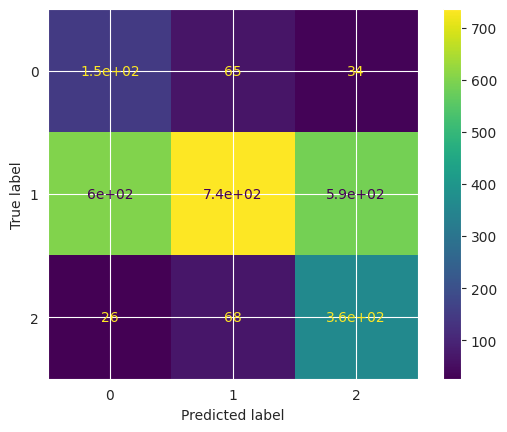

In [39]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=sum_confusion_matrix_rf,
                              display_labels=clf.classes_)
disp.plot()

plt.show()

In [43]:
calculate_accuracy(sum_confusion_matrix_rf)

{0: 72.33637747336378, 1: 49.65753424657534, 2: 72.75494672754947}